# Import necessary libraries

In [1]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import importlib

In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import lib
importlib.reload(lib)

<module 'lib' from 'c:\\Users\\dongq\\OneDrive\\Desktop\\New results\\Portfolio Allocation\\Learning-the-Optimal-Solution-Path\\lib\\__init__.py'>

In [7]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.ngs.naive_grid_search_2d import naive_grid_search_2d
from lib.ngs.utils_ngs_2d import get_sup_error_2d
from lib.ngs.loss_fn import allocation_cost_no_con

# Load data

In [8]:
# file path
decomp_cov_df = pd.read_csv('decomp_cov.csv')
mean_df = pd.read_csv('mean.csv')

In [9]:
decomp_cov = np.array(decomp_cov_df)
mean = np.array(mean_df).squeeze()

In [10]:
decomp_cov = torch.tensor(decomp_cov, dtype=torch.float32)
mean = torch.tensor(mean, dtype=torch.float32)

In [11]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(decomp_cov, mean, batch_size=len(decomp_cov), shuffle=False, )
# test data
test_data_loader = FastTensorDataLoader(decomp_cov, mean, batch_size=len(decomp_cov), shuffle=False, )

In [12]:
lam_max_2d = [1, 1]
lam_min_2d = [.2, 0]
input_dim = decomp_cov.shape[1]

In [13]:
import time

In [14]:
# Read the CSV file into a DataFrame
# truth = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/results/exact_soln_list.csv')
truth = pd.read_csv('exact_soln_list_cov_001_100_100_no_con.csv')

# Display the DataFrame
truth

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.013926,-0.013637,-0.013352,-0.013070,-0.012791,-0.012515,-0.012242,-0.011973,-0.011707,-0.011445,...,-0.000112,-0.000088,-0.000068,-0.000050,-0.000034,-0.000022,-0.000012,-0.000006,-0.000001,0.0
1,-0.014002,-0.013711,-0.013424,-0.013140,-0.012859,-0.012582,-0.012308,-0.012038,-0.011770,-0.011506,...,-0.000112,-0.000089,-0.000068,-0.000050,-0.000035,-0.000022,-0.000012,-0.000006,-0.000001,0.0
2,-0.014078,-0.013786,-0.013497,-0.013211,-0.012929,-0.012650,-0.012375,-0.012103,-0.011834,-0.011568,...,-0.000113,-0.000089,-0.000068,-0.000050,-0.000035,-0.000022,-0.000013,-0.000006,-0.000001,0.0
3,-0.014155,-0.013861,-0.013571,-0.013284,-0.013000,-0.012719,-0.012442,-0.012169,-0.011898,-0.011631,...,-0.000113,-0.000090,-0.000069,-0.000050,-0.000035,-0.000022,-0.000013,-0.000006,-0.000001,0.0
4,-0.014234,-0.013938,-0.013646,-0.013357,-0.013071,-0.012789,-0.012511,-0.012235,-0.011963,-0.011695,...,-0.000114,-0.000090,-0.000069,-0.000051,-0.000035,-0.000023,-0.000013,-0.000006,-0.000001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.034586,-0.033755,-0.032940,-0.032141,-0.031358,-0.030589,-0.029835,-0.029096,-0.028371,-0.027660,...,-0.000249,-0.000197,-0.000151,-0.000111,-0.000077,-0.000049,-0.000028,-0.000012,-0.000003,0.0
96,-0.035320,-0.034465,-0.033626,-0.032804,-0.031998,-0.031208,-0.030434,-0.029675,-0.028930,-0.028200,...,-0.000253,-0.000200,-0.000153,-0.000112,-0.000078,-0.000050,-0.000028,-0.000012,-0.000003,0.0
97,-0.036098,-0.035216,-0.034352,-0.033505,-0.032676,-0.031863,-0.031066,-0.030285,-0.029520,-0.028770,...,-0.000257,-0.000203,-0.000155,-0.000114,-0.000079,-0.000051,-0.000029,-0.000013,-0.000003,0.0
98,-0.036925,-0.036015,-0.035123,-0.034249,-0.033394,-0.032556,-0.031735,-0.030931,-0.030143,-0.029372,...,-0.000261,-0.000206,-0.000158,-0.000116,-0.000080,-0.000051,-0.000029,-0.000013,-0.000003,0.0


In [15]:
true_losses = truth.to_numpy()

# Loss function

In [16]:
loss_fn = allocation_cost_no_con

For BFGS, use a constant default learning rate .1

In [17]:
lr = .1

## Assume no access to true loss

In [18]:
max_epochs = 5

In [28]:
num_grid_list = np.arange(4, 20)
num_grid_list

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [29]:
delta_list = 1/(num_grid_list**2)
delta_list

array([0.0625    , 0.04      , 0.02777778, 0.02040816, 0.015625  ,
       0.01234568, 0.01      , 0.00826446, 0.00694444, 0.00591716,
       0.00510204, 0.00444444, 0.00390625, 0.00346021, 0.00308642,
       0.00277008])

In [30]:
np.round(.65 * np.log(1/delta_list))

array([2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.])

$\max_{\lambda \in \text{Grid}} h(\theta(\lambda), \lambda) - h(\theta^*(\lambda), \lambda)$

In [31]:
total_evals_list = []
total_grad_calls_list = []
sup_error_list = []
grid_error_list = []
for num_grid in num_grid_list:
    # number of grids according to 1/sqrt(delta)
    delta = 1/(num_grid**2)
    epochs = round(.65 * np.log(1/delta))
    num_grid_2d = [num_grid, num_grid]

    # start_time = time.time()
    total_evals_2d, total_grad_calls_2d, hyper_params, intercepts, weights, grid_pass_error = naive_grid_search_2d(lam_min_2d=lam_min_2d, lam_max_2d=lam_max_2d,
                                num_grid_2d=num_grid_2d, epochs=epochs, loss_fn=loss_fn,
                                trainDataLoader=GD_data_loader, data_input_dim=input_dim,
                                lr=lr, weighted_avg=False, testDataLoader=test_data_loader,
                                oracle=False, true_loss_list=true_losses, stopping_criterion=delta,
                                check_frequency=1, device=device)

    # end_time = time.time()
    # execution_time = end_time - start_time

    total_evals_list.append(total_evals_2d)
    total_grad_calls_list.append(total_grad_calls_2d)

    # solution path error
    sup_error = get_sup_error_2d(lam_min_2d, lam_max_2d, true_losses, intercepts,
                                  weights, np.array(hyper_params), test_data_loader, loss_fn, device)

    sup_error_list.append(sup_error)
    grid_error_list.append(grid_pass_error)
    # print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")
    print(f"grid #: {num_grid} by {num_grid}\t total func evals #: {total_evals_2d}\t total grad calls #: {total_grad_calls_2d}\t sup error: {sup_error}\t grid pass error: {grid_pass_error}")

total_evals_list = np.array(total_evals_list)
total_grad_calls_list = np.array(total_grad_calls_list)
sup_error_list = np.array(sup_error_list)
grid_error_list = np.array(grid_error_list)

grid #: 4 by 4	 total func evals #: 320	 total grad calls #: 32	 sup error: 0.03922995693403262	 grid pass error: 0.018281086797431068
grid #: 5 by 5	 total func evals #: 500	 total grad calls #: 50	 sup error: 0.020005551994414714	 grid pass error: 0.008372961432241423
grid #: 6 by 6	 total func evals #: 720	 total grad calls #: 72	 sup error: 0.010554493080708148	 grid pass error: 0.0036291819025368825
grid #: 7 by 7	 total func evals #: 1470	 total grad calls #: 147	 sup error: 0.003122817792286948	 grid pass error: 0.00038353433798536153
grid #: 8 by 8	 total func evals #: 1920	 total grad calls #: 192	 sup error: 0.0020624966051330934	 grid pass error: 0.00038353433798536153
grid #: 9 by 9	 total func evals #: 2430	 total grad calls #: 243	 sup error: 0.0014964851730288574	 grid pass error: 0.00038353433798536153
grid #: 10 by 10	 total func evals #: 3000	 total grad calls #: 300	 sup error: 0.0013065668176744406	 grid pass error: 0.00038353433798536153
grid #: 11 by 11	 total fun

In [32]:
df = pd.DataFrame(np.column_stack((total_evals_list, total_grad_calls_list, sup_error_list, grid_error_list, delta_list)), columns=['num_func_eval', 'num_grad_call', 'sup_err', 'grid_err', 'delta'])

# Save the DataFrame to a CSV file
df.to_csv('NGS_results_exact_2d_no_con.csv', index=False)

In [5]:
# Read the CSV file into a DataFrame
df = pd.read_csv('NGS_results_exact_2d_no_con.csv')

In [6]:
sup_error_list = df['sup_err']
grid_error_list = df['grid_err']
delta_list = df['delta']
total_evals_list = df['num_func_eval']
total_grad_calls_list = df['num_grad_call']

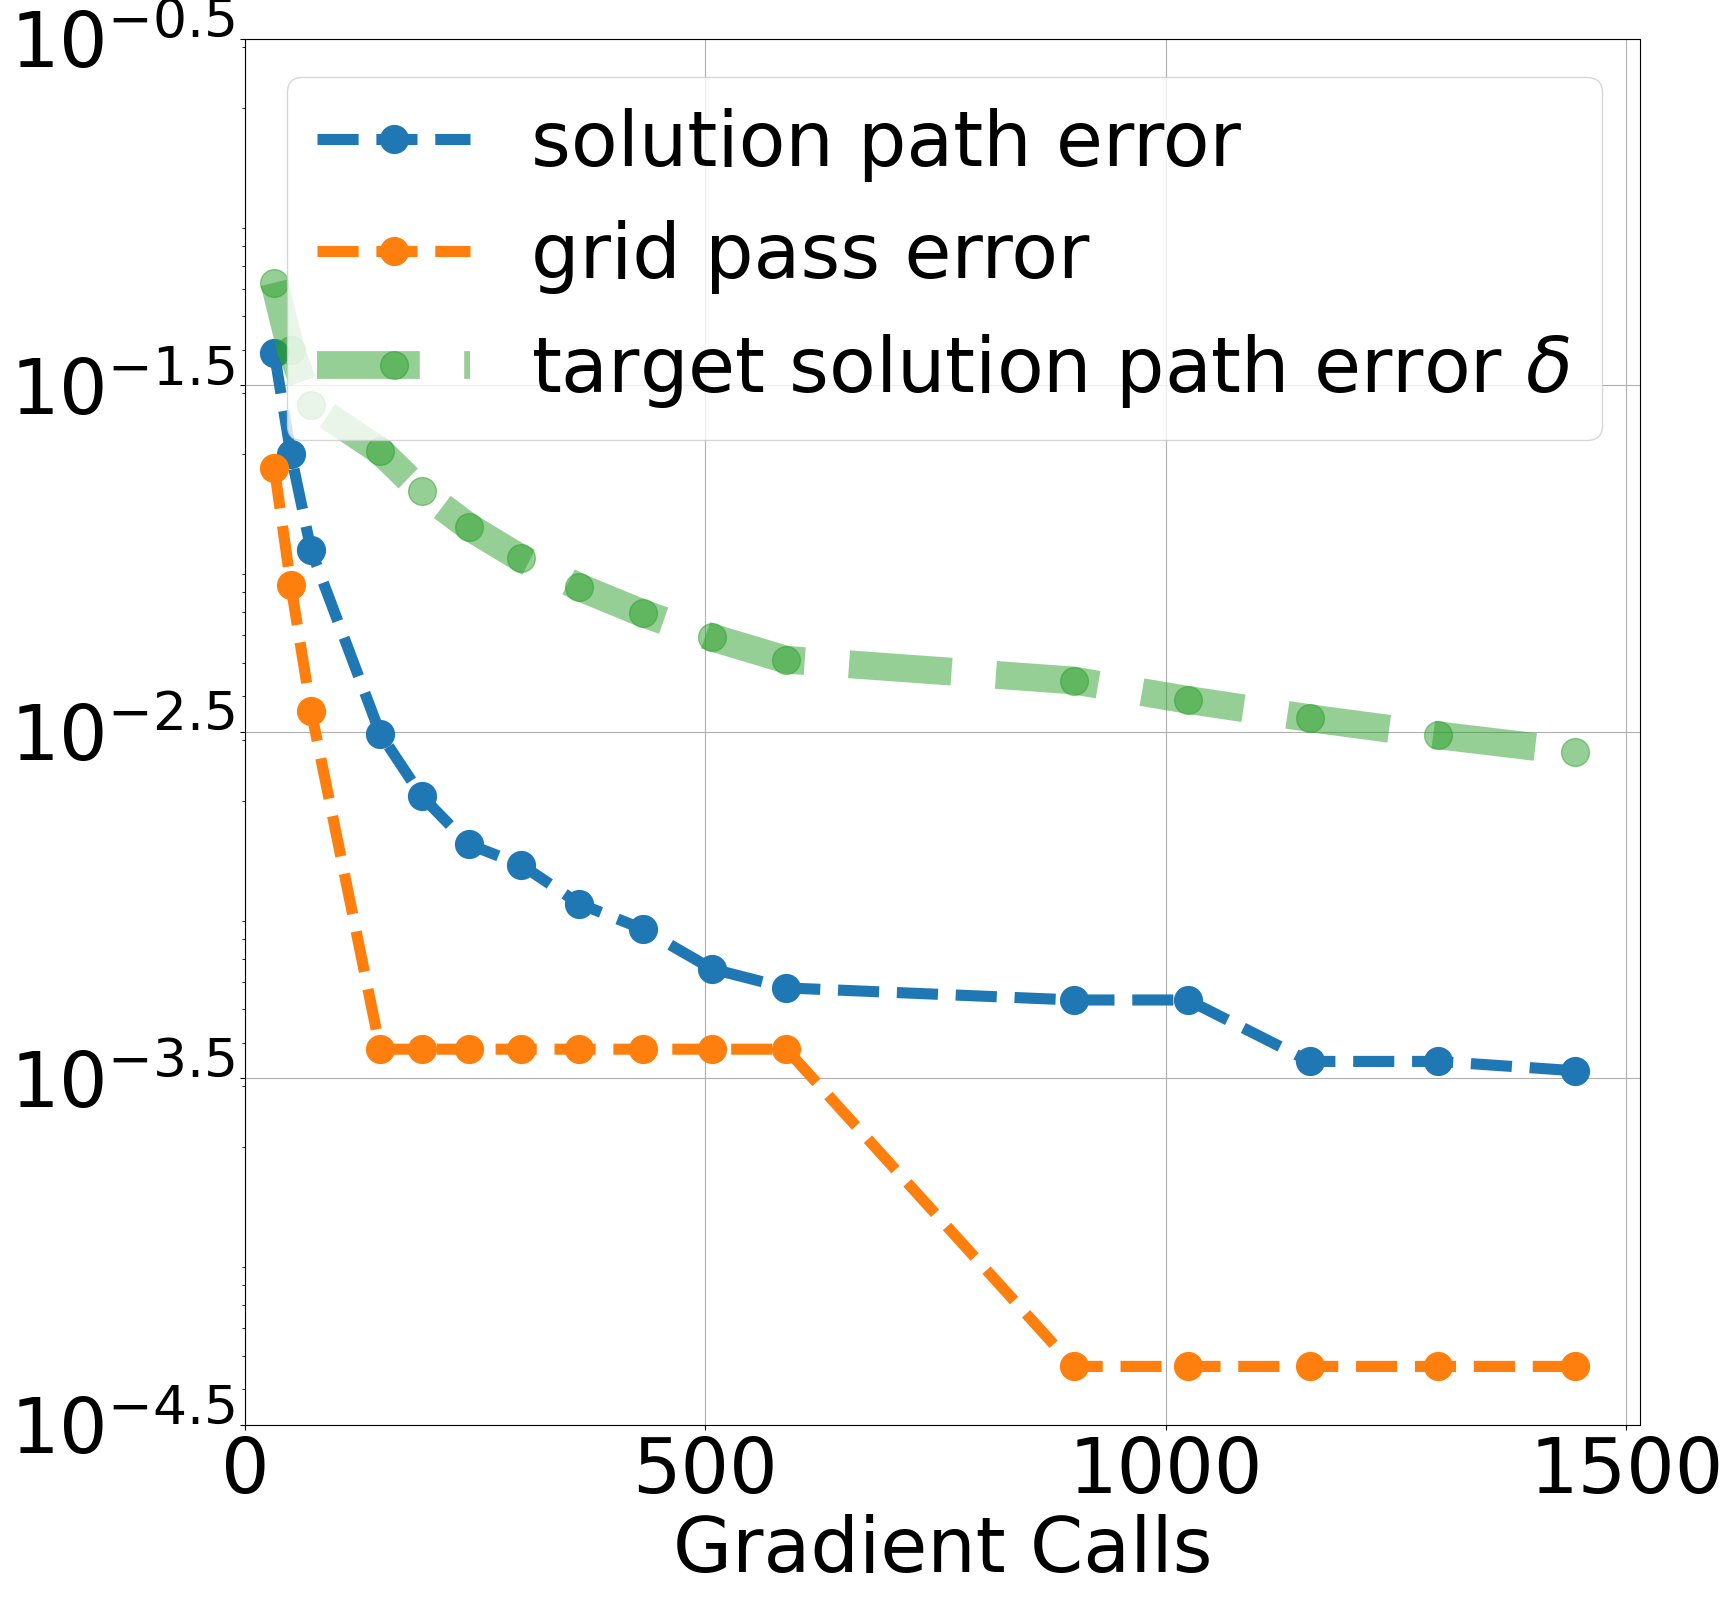

In [14]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(total_grad_calls_list, (sup_error_list), '--o', linewidth=8, markersize=20, label="solution path error")
plt.plot(total_grad_calls_list, (grid_error_list), '--o', linewidth=8, markersize=20, label="grid pass error")
plt.plot(total_grad_calls_list, (delta_list), '--o', linewidth=20, markersize=20, label="target solution path error $\\delta$", alpha=0.5)

# Set global font size
mpl.rcParams['font.size'] = 55

font_size = 55
# Tick labels
plt.yscale('log')

ticks = np.arange(-4.5, 0, 1)  # Tick positions in powers of 10
tick_labels = [f'$10^{{{t}}}$' for t in ticks]  # LaTeX-formatted labels

# Set the y-ticks and labels
# plt.yticks()

plt.xticks(fontsize=font_size)
plt.yticks(10**ticks, tick_labels, fontsize=font_size)
# plt.yticks(fontsize=font_size)

plt.xlim(0,)

# Legend, if applicable
plt.legend(fontsize=font_size)

plt.xlabel('Gradient Calls', fontsize=font_size)
# plt.ylabel('Error', fontsize=font_size)
plt.legend()
plt.grid(True)
plt.savefig("NGS_stopping_criterion_exact_2d_no_con.png")